In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.1 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
Path.BASE_PATH = path

List what we have in the path

In [ ]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

Extract threes and sevens for the model prediction

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevenths = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

Illustrate one image to see what we work with

In [ ]:
im3_path = threes[1]
image = Image.open(im3_path)
image

An array representation of the image

In [ ]:
array(image)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The same representation, but using tensor instead of numpy. I will use tensor, because it allows to use GPU unlike Numpy

In [ ]:
tensor(image)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [ ]:
image_t = tensor(image)
df = pd.DataFrame(image_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Represent all the images as tensors

In [ ]:
three_tensor = [tensor(Image.open(o)) for o in threes]
seven_tensor = [tensor(Image.open(o)) for o in sevenths]
len(three_tensor), len(seven_tensor)

(6131, 6265)

<Axes: >

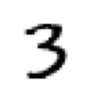

In [ ]:
show_image(three_tensor[1])

Here we created a tensor, that has 6131 samples with the size of 28 pixels by 28 pixels each. We can imagine the tensor as cube

In [ ]:
stacked_sevens = torch.stack(seven_tensor).float() / 255
stacked_threes = torch.stack(three_tensor).float() / 255
stacked_threes.shape

torch.Size([6131, 28, 28])

The length of a tensor's shape is its rank:

In [ ]:
len(stacked_threes.shape)

3

Here is how "ideal" three looks like

<Axes: >

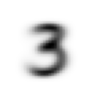

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

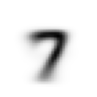

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

Lets take the first image and calculate the distance of pixels between it and "ideal" number 3.

<Axes: >

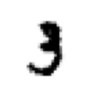

In [ ]:
a_3 = stacked_threes[0]
show_image(a_3)

To calculate the distance between our ideal number 3 and arbitrary number we may follow two ways:
1. Take the mean of the _absolute value_ of differences (absolute value is the function that replaces negative values with positive values). This is called the __mean absolute difference__ or __L1 norm__.
2. Take the mean of the _square_ of differences (which makes everything positive) and then take the _square root_ (which undoes the squaring). This is called the __root mean squarred error (RMSE)__ or __L2 norm__.

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).sqrt().mean()
dist_3_abs, dist_3_sqr

(tensor(0.1074), tensor(0.1074))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).sqrt().mean()
dist_7_abs, dist_7_sqr

(tensor(0.1441), tensor(0.1441))

Intuitively the difference between _L1 norm_ and _mean squared error (MSE)_ is that the latter will penalize bigger mistakes more heavily that the former (and be more lenient with small mistakes)

Let us get a valid set of our 3s and 7s from 'valid' folder

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float() / 255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float() / 255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [ ]:
def mnist_distance(a, b): return (a - b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1074)

Let us calculate mean absolute error for validation set

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1320, 0.1578, 0.1642,  ..., 0.1156, 0.1242, 0.1061]),
 torch.Size([1010]))

In [ ]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

To see the prediction on all 3s

In [ ]:
is_3(valid_3_tens)

Let us calculate the accuracy

In [ ]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s) / 2

Let's concatenate the images into a 2-rank tensor. To do it we will use __view__. -1 means make the axis as big as necessary to fill all the data

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a lable for each image. We will use 1 for 3s and 0 for 7s

In [ ]:
train_y = tensor([1] * len(threes), [0] * len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an initially random weight for every pixel

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

The function weights*pixels won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). You might remember from high school math that the formula for a line is y=w*x+b; we still need the b. We'll initialize it to a random number too:

In [ ]:
bias = init_params(1)

To calculate the prediction we will use matrices multiplication

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x1)
preds

Let's check our accuracy

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
batch = train_x[:4]
batch.shape

In [ ]:
preds = linear1(batch)
preds

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')